In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

In [2]:
from torch import nn
from torch.autograd import Variable
import torch

In [57]:
def get_x(batch_size):
    return Variable(torch.randn(batch_size, 1)).cuda()

def get_y(batch_size):
    return to_var(np.random.uniform(size=(batch_size, 1)))

def to_np(x):
    return x.data.cpu().numpy()

def to_var(x):
    return Variable(torch.from_numpy(np.asarray(x).astype('float32'))).cuda()

In [120]:
discriminator = nn.Sequential(
    nn.Linear(1, 20),
    nn.ReLU(inplace=True),
    nn.Linear(20, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 20),
    nn.ReLU(inplace=True),
    nn.Linear(20, 1),
    nn.Sigmoid()
).cuda()

generator = nn.Sequential(
    nn.Linear(1, 20),
    nn.ReLU(inplace=True),
    nn.Linear(20, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 20),
    nn.ReLU(inplace=True),
    nn.Linear(20, 1),
    nn.Sigmoid()
).cuda()

g_optimizer = torch.optim.Adam(generator.parameters())
d_optimizer = torch.optim.Adam(discriminator.parameters())

In [121]:
losses = []

In [122]:
from dpipe.torch.model import set_lr
from dpipe.train.lr_policy import Exponential

In [123]:
lr = Exponential(
    1e-4, .1, 50000, False
)

In [124]:
batch_size = 1000

In [149]:
for _ in tqdm(range(10000)):
    set_lr(g_optimizer, lr.lr)
    set_lr(d_optimizer, lr.lr)
    
    x = get_x(batch_size)
    fake_y = generator(x)
    
    g_optimizer.zero_grad()
    loss_g = torch.pow(1 - discriminator(fake_y), 2).mean()
    loss_g.backward()
    g_optimizer.step()
    
    x, y = get_x(batch_size), get_y(batch_size)
    fake_y = generator(x)
    
    d_optimizer.zero_grad()
    loss_d_real = ((1 - discriminator(y)) ** 2).mean()
    loss_d_fake = ((discriminator(fake_y)) ** 2).mean()
    (loss_d_real + loss_d_fake).backward()
    d_optimizer.step()
    
    losses.append([to_np(i)[0] for i in (loss_g, loss_d_real, loss_d_fake)])
    
    lr.epoch_finished()

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

In [150]:
lr.lr

8.710037002352225e-06

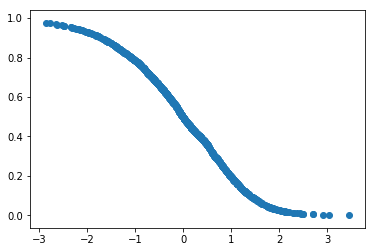

In [151]:
x_, y_ = to_np(x).flatten(), to_np(fake_y).flatten()
plt.scatter(x_, y_)

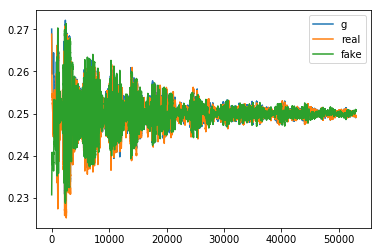

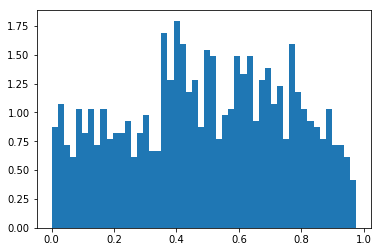

In [153]:
for t, name in zip(zip(*losses), ['g', 'real', 'fake']):
    plt.plot(t, label=name)
plt.legend()

plt.figure()
plt.hist(to_np(fake_y).flatten(), bins=50, normed=True);